In [1]:
import requests 
import json
from pprint import pprint
import os
import pandas as pd
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as sts
import gmaps
from scipy.stats import sem
from scipy.stats import linregress


In [2]:
# # Import Merged GDP and Weather data
merge_path = os.path.join("Resources", "Merge_data_2005-2015.csv")
merge_df = pd.read_csv(merge_path)

merge_df.head()

,Unnamed: 0,ISO3,Country,Year,Temp_Farenheit,Rainfall_mm,GDP,GDP_md,GDP_bd
0,0,AFG,Afghanistan,2005,56.087945,29.609967,6.209138e+09,6209.137625,6.209138
1,1,AFG,Afghanistan,2006,57.501470,27.120458,6.971286e+09,6971.285595,6.971286
2,2,AFG,Afghanistan,2007,56.320054,25.329681,9.747880e+09,9747.879532,9.747880
3,3,AFG,Afghanistan,2008,56.755070,21.505365,1.010923e+10,10109.225814,10.109226
4,4,AFG,Afghanistan,2009,56.807912,31.106477,1.243909e+10,12439.087077,12.439087


In [3]:
# # Understand the data
max_Rain = merge_df['Rainfall_mm'].max()
min_Rain = merge_df['Rainfall_mm'].min()
print(f"Maximum temperature in data is {max_Rain}")
print(f"Minimum temperature in data is {min_Rain}")

max_GDP = merge_df['GDP_bd'].max()
min_GDP = merge_df['GDP_bd'].min()
print(f"Maximum Gross Domestic Product in data is {max_GDP}")
print(f"Minimum Gross Domestic Product in data is {min_GDP}")

Maximum temperature in data is 736.4781750000002
Minimum temperature in data is 1.6598875000000002
Maximum Gross Domestic Product in data is 18219.3
Minimum Gross Domestic Product in data is 0.02183909889


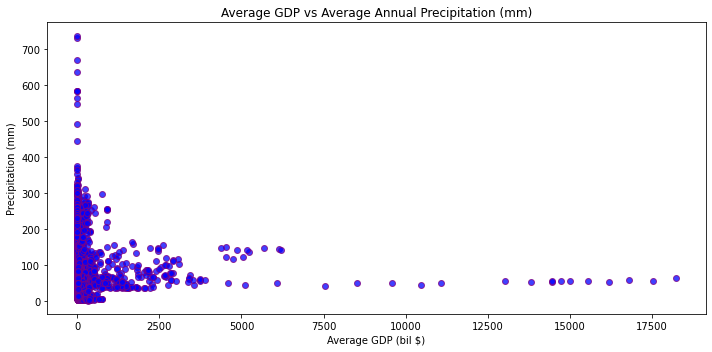

In [4]:
# # Plot all the data
# Plot the Rainfall versus GDP data to look for trend/features to investigate
ListofISO34Plot = merge_df['ISO3']
# # Make Scatter plot of Rainfall vs GDP  
plt.figure(figsize=(10,5))
plt.scatter(merge_df["GDP_bd"], merge_df["Rainfall_mm"], marker='o', facecolor='b', edgecolors='purple', alpha = 0.75)
plt.title(f"Average GDP vs Average Annual Precipitation (mm)")
plt.xlabel("Average GDP (bil $)")
plt.ylabel("Precipitation (mm)")
plt.tight_layout()
plt.savefig("output_data/Q2/Fig1x_AvTemp_vs_GDP_AllCountries.png")
plt.show()

In [5]:
# Crop data to area of interest
zone1_df = merge_df.loc[(merge_df['Rainfall_mm']>=150) & (merge_df['Rainfall_mm']<=250)]
zone1_df

zone2_df = merge_df.loc[(merge_df['Rainfall_mm']>=50) & (merge_df['Rainfall_mm']<=149)]
zone2_df

zone3_df = merge_df.loc[(merge_df['Rainfall_mm']> 0) & (merge_df['Rainfall_mm']<=49)]
zone3_df

# Create a merged (zone1, 2 & 3) dataframe
ZONE_df = merge_df.loc[(merge_df['Rainfall_mm']>=150) & (merge_df['Rainfall_mm']<=250) | (merge_df['Rainfall_mm']>=50) & (merge_df['Rainfall_mm']<=149) | (merge_df['Rainfall_mm']> 0) & (merge_df['Rainfall_mm']<=49)]
ZONE_df = ZONE_df.dropna(how='any')


# # Understand the data
ZoneCountries = merge_df['ISO3'].nunique()
print(f"No. of countries after filter {ZoneCountries}")

ZONE_df

No. of countries after filter 188


,Unnamed: 0,ISO3,Country,Year,Temp_Farenheit,Rainfall_mm,GDP,GDP_md,GDP_bd
0,0,AFG,Afghanistan,2005,56.087945,29.609967,6.209138e+09,6209.137625,6.209138
1,1,AFG,Afghanistan,2006,57.501470,27.120458,6.971286e+09,6971.285595,6.971286
2,2,AFG,Afghanistan,2007,56.320054,25.329681,9.747880e+09,9747.879532,9.747880
3,3,AFG,Afghanistan,2008,56.755070,21.505365,1.010923e+10,10109.225814,10.109226
4,4,AFG,Afghanistan,2009,56.807912,31.106477,1.243909e+10,12439.087077,12.439087
...,...,...,...,...,...,...,...,...,...
2063,2140,ZWE,Zimbabwe,2011,71.085215,63.126104,1.410192e+10,14101.920300,14.101920
2064,2141,ZWE,Zimbabwe,2012,71.438135,45.312368,1.711485e+10,17114.849900,17.114850
2065,2142,ZWE,Zimbabwe,2013,70.923830,51.234424,1.909102e+10,19091.020000,19.091020
2066,2143,ZWE,Zimbabwe,2014,71.078870,50.608135,1.949552e+10,19495.519600,19.495520


In [6]:
# # LOOKING FOR REGRESSIONS
# Looking at the trend line for precipitation over time (10yrs) for each country and GDP over time for 
# the same country storing these values to compare them.

# FOR COMBINED ZONES OF INTEREST
# Initialize lists and dictionairies needed
ListofISO3_Merged = merge_df['ISO3']
ZONERegressList = []
ZONERegressDictGDP = {}
ZONERegressDictRain = {}
ZONEPvalueDictGDP = {}
ZONEPvalueDictRain = {}
R_ValuesGDP = {}
R_ValuesRain = {}
P_ValuesGDP = {}
P_ValuesRain = {}

# Run for-loop to get regression values for GDP for each country (store rvalue & pvalue)
for ISO in ListofISO3_Merged:
    ZONECorrelation_df = merge_df.loc[merge_df['ISO3']== ISO]
    GDP = ZONECorrelation_df['GDP']
    Rain = ZONECorrelation_df['Rainfall_mm']
    Yrs = ZONECorrelation_df['Year']    

    #  LINEAR REGRESSION MODEL 
    # Run the regression and store each of the returned values
    slope, intercept, rvalue, pvalue, stderr = linregress(Yrs, GDP)
    Zone_regression = [slope, intercept, rvalue, pvalue, stderr]
    Zone_Rvalue = Zone_regression[2]
    Zone_Pvalue = Zone_regression[3]
    ZONERegressDictGDP[ISO] = Zone_Rvalue
    ZONEPvalueDictGDP[ISO] = Zone_Pvalue
R_ValuesGDP = ZONERegressDictGDP
P_ValuesGDP = ZONEPvalueDictGDP

# Run for-loop to get regression values for annual average Precipitation for each country
for ISO in ListofISO3_Merged:
    ZONECorrelation_df = merge_df.loc[merge_df['ISO3']== ISO]
    GDP = ZONECorrelation_df['GDP']
    Rain = ZONECorrelation_df['Rainfall_mm']
    Yrs = ZONECorrelation_df['Year']    

    #  LINEAR REGRESSION MODEL 
    # Run the regression and store each of the returned values
    slope, intercept, rvalue, pvalue, stderr = linregress(Yrs, Rain)
    Zone_regression = [slope, intercept, rvalue, pvalue, stderr]
    Zone_Rvalue = Zone_regression[2]
    Zone_Pvalue = Zone_regression[3]
    ZONERegressDictRain[ISO] = Zone_Rvalue
    ZONEPvalueDictRain[ISO] = Zone_Pvalue
R_ValuesRain = ZONERegressDictRain
P_ValuesRain = ZONEPvalueDictRain


In [7]:
# # COMPARING REGRESSION VALUES FOR GDP AND PRECIPITATION
# Looking at the difference between the r-value for the GDP trend line and the annual precipitation of a given 
# country would help ascertain any relationship.
# For example, a high, positive r-value for the GDP trend line and a similarly high, positive r-value for the 
# annual Precipitation trend line indicates the possibility of a correlation.

# Create a df to look at the GDP and precipitation regressions
RegressList ={"RAIN_REGRESS": R_ValuesRain,"GDP_REGRESS": R_ValuesGDP, "RAIN_PVALUE": P_ValuesRain,"GDP_PVALUE": P_ValuesGDP}
Regress_df = pd.DataFrame(RegressList)
Regress_df = Regress_df.reset_index()
Regress_df = Regress_df.rename(columns={'index': 'ISO3'})
Regress_df['Regression_diff'] = Regress_df['RAIN_REGRESS'] - Regress_df['GDP_REGRESS']
Regress_df = Regress_df.sort_values(by='Regression_diff', ascending=True)
Regress_df

# # Understand the max and min of the regresssion difference data
maxRegressionDiff = Regress_df['Regression_diff'].max()
minRegressionDiff = Regress_df['Regression_diff'].min()
print(f"Maximum regression difference in data is {round(maxRegressionDiff,4)}")
print(f"Minimum regression difference in data is {round(minRegressionDiff,4)}")

# DIVING DEEPER
#  Only look at data with a statistically significant p-value (p-value < alpha)
step1_df = Regress_df.loc[(Regress_df['RAIN_PVALUE']<=0.25) & (Regress_df['GDP_PVALUE']<=0.25)]
# Create a subset of data based on the regression differences: Regression values > 1.1, less than -1.6 and close to 0
Regress_Subset_df = step1_df.loc[(Regress_df['Regression_diff']>=1.1) | (Regress_df['Regression_diff']>=-0.3) & (Regress_df['Regression_diff']<=0.3) | (Regress_df['Regression_diff']<=-1.6)]

# # Understand the data
RegressSubsetList = Regress_Subset_df['ISO3']
RegressSubsetNo = Regress_Subset_df['ISO3'].nunique()
print(f"No. of countries after filter {RegressSubsetNo}")
RegressSubsetList

Maximum regression difference in data is 1.2106
Minimum regression difference in data is -1.7338
No. of countries after filter 8


72     GUY
49     DOM
123    NIC
133    PRY
82     ISR
67     GRL
32     CAF
126    MNP
Name: ISO3, dtype: object

In [ ]:
# # Dual axis bar/line chart
# A bar chart/line graph to compare GDP and annual Precipitation trends over time.
# Make a ISO List based on findings from regress data frame
# RegressList = ['MNP', 'AND', 'GRC', 'ISL', 'JPN', 'CYP', 'DNK', 'IRL', 'LBY', 'SVN', 'CAF', 'ITA', 'GUY', 'DOM', 'NIC', 'CRI', 'KNA', 'NGA']
for ISO in RegressSubsetList:
    BarGraph_df = merge_df.loc[merge_df['ISO3']== ISO]
    yearList = BarGraph_df['Year'].unique()
    yearNo = np.array(range(len(yearList)))
    GDPNos = BarGraph_df['GDP_bd']
    RainNos = BarGraph_df['Rainfall_mm']
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(yearList, GDPNos, color=(63/255,79/255,232/255,0.7), label='GDP(bill $)')
    ax2.plot(yearList, RainNos, color='red', label='Precipitation(mm)')
    ax.set_xticklabels(yearList)
    ax.legend(loc='center left', bbox_to_anchor=(0, -0.2))
    ax2.legend(loc='center left', bbox_to_anchor=(0.6, -0.2))
    ax.set_title(f"GDP bars and Average Annual Precipitation(mm) Line Graph_{ISO}")
    ax.set_ylabel('GDP (bil,$)')
    ax2.set_ylabel('Precipitation(mm)')
    ax.set_xlabel('Time (Yr.)')
    plt.tight_layout()
    plt.savefig(f"output_data/Q2/Fig2_GDP_BarChart_RainLineChart_{ISO}_2005-2015.png")
